### 필요 라이브러리 import

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import segmentation_models as sm

import cv2

from PIL import Image

import zipfile

c:\Users\User\anaconda3\envs\ml_pipeline\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Segmentation Models: using `tf.keras` framework.


### mlflow 설정

In [4]:
os.environ["AWS_ACCESS_KEY_ID"] = ""

os.environ["AWS_SECRET_ACCESS_KEY"] = ""

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://s3.ap-northeast-2.amazonaws.com"

In [5]:
mlflow_uri = "http://3.35.215.88:5000/"
mlflow.set_tracking_uri(mlflow_uri)

In [19]:
exp_id = mlflow.create_experiment("repair_cost")
exp_id

'2'

### mlflow에 올릴 파이프라인 작성

#### scratch인식 모델

In [55]:
tf.keras.backend.clear_session()

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
class RepairCostScratchModel(mlflow.pyfunc.PythonModel):
    def __init__(self, weight_path):
        self.model = smp.Unet(classes = 16, encoder_name='resnet34', encoder_weights='imagenet', in_channels=3).to(device)
        self.model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))
        self.model.eval()
        
    def preprocess_data(self, img_path):
        img  = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img_input = img / 255.
        img_input = img_input.transpose([2, 0, 1])
        img_input = torch.tensor(img_input).float().to(device)
        img_input = img_input.unsqueeze(0)
        return img_input, img

    def predict(self, context, img_path):
        img_input, img_org = self.preprocess_data(img_path)
        output = self.model(img_input)
        img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
        img_output = img_output.transpose([1, 2, 0])
        
        result_image = img_output
        cmap = plt.get_cmap('Accent_r')
        result_image = cmap(result_image.squeeze())[:, :, :3] * 255
        result_image = result_image.astype(np.uint8)
        
        new_img = cv2.addWeighted(img_org, 0.5, result_image, 0.5, 0)
        layered_img = Image.fromarray(new_img)
        return img_output, layered_img

In [58]:
weight_path = r'C:\Users\User\MLOps2\parts\[PART]Unet.pt'
model_scratch = RepairCostScratchModel(weight_path)

In [59]:
with mlflow.start_run(experiment_id=2):  # 추적 시작 지정
    
    mlflow.pyfunc.log_model(artifact_path="model_scratch_layered", python_model=model_scratch)

In [63]:
# local mlflow
logged_model = 'runs:/e4ecc6bbf5ce4fed828518c15aa7f259/model_scratch_layered'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

2023/07/01 15:29:50 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.4.1, required: mlflow==2.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [64]:
path = 'C:/Users/User/repair_cost/test_image/0000095_sc-126705.jpg'
result, layered = loaded_model.predict(path)

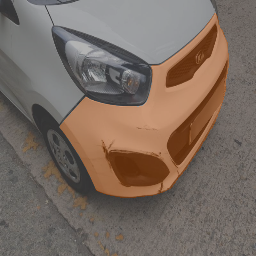

In [65]:
layered

#### parts인식 모델

In [12]:
# git lfs install
!git clone https://huggingface.co/spaces/Armandoliv/cars-parts-segmentation-resnet18

fatal: destination path 'cars-parts-segmentation-resnet18' already exists and is not an empty directory.


In [34]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import matplotlib.colors as colorsHTML
from PIL import Image

In [35]:
import mlflow
import torch
import tensorflow as tf
import torch.nn as nn

In [36]:
# os.system('wget https://huggingface.co/Armandoliv/cars-parts-segmentation-unet-resnet18/resolve/main/best_model.h5')

c= ['_background_', 'back_bumper', 'back_glass', 'back_left_door','back_left_light',
 'back_right_door', 'back_right_light', 'front_bumper','front_glass',
 'front_left_door',  'front_left_light', 'front_right_door',  'front_right_light',  'hood',  'left_mirror',
 'right_mirror', 'tailgate',  'trunk', 'wheel']

colors = [ 	(255,255,255), (255,0,0),  (255,255,255), (32,178,170),(255,255,255),
 (0,255,255), (255,255,255), (0,255,0), (255,255,255), (85,107,47),
  (255,255,255), (0,191,255), (255,255,255), (255,255,255), (255,255,255),
          (255,255,255), (255,255,255), (255,255,0), (255,255,255)]


In [37]:
sm.set_framework('tf.keras')

sm.framework()

In [38]:
class RepairCostPartsModel(mlflow.pyfunc.PythonModel):
    def __init__(self):
        BACKBONE = 'resnet18'
        n_classes = 19
        activation =  'softmax'
        self.model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
        self.model.load_weights('best_model.h5')

    def get_colored_segmentation_image(self, seg_arr, n_classes, colors=colors):
        output_height = seg_arr.shape[0]
        output_width = seg_arr.shape[1]

        seg_img = np.zeros((output_height, output_width, 3))

        for c in range(n_classes):
            seg_arr_c = seg_arr[:, :] == c
            # print(sum(sum(seg_arr_c)), colors[c] )
            seg_img[:, :, 0] += ((seg_arr_c)*(colors[c][0])).astype('uint8')
            seg_img[:, :, 1] += ((seg_arr_c)*(colors[c][1])).astype('uint8')
            seg_img[:, :, 2] += ((seg_arr_c)*(colors[c][2])).astype('uint8')

        return seg_img/255

    def get_legends(self, class_names, colors, tags):

        n_classes = len(class_names)
        legend = np.zeros(((len(class_names) * 25) + 25, 125, 3),
                        dtype="uint8") + 255

        class_names_colors = enumerate(zip(class_names[:n_classes],
                                        colors[:n_classes]))
        j = 0
        for (i, (class_name, color)) in class_names_colors:
            if i in tags:
                color = [int(c) for c in color]
                cv2.putText(legend, class_name, (5, (j * 25) + 17),
                            cv2.FONT_HERSHEY_COMPLEX, 0.35, (0, 0, 0), 1)
                cv2.rectangle(legend, (100, (j* 25)), (125, (j * 25) + 25),
                                tuple(color), -1)
                j +=1
        return legend

    def preprocess_image(self, path_img):
        img = Image.open(path_img)
        img = img.resize((256, 256))
        ww = 256
        hh = 256
        img.thumbnail((hh, ww))
        i = np.array(img)
        ht, wd, cc= i.shape

        # create new image of desired size and color (blue) for padding
        color = (0,0,0)
        result = np.full((hh,ww,cc), color, dtype=np.uint8)

        # copy img image into center of result image
        result[:ht, :wd] = img
        return result, ht, wd
    
    def concat_lengends(self, seg_img, legend_img):
        new_h = np.maximum(seg_img.shape[0], legend_img.shape[0])
        new_w = seg_img.shape[1] + legend_img.shape[1]

        out_img = np.zeros((new_h, new_w, 3)).astype('uint8') + legend_img[0, 0, 0]

        out_img[:legend_img.shape[0], :  legend_img.shape[1]] = np.copy(legend_img)
        out_img[:seg_img.shape[0], legend_img.shape[1]:] = np.copy(seg_img)

        return out_img

    def predict(self, context, filename):
        #load the image
        img_path = filename
        img = Image.open(img_path).convert("RGB")
        img = img.resize((256, 256))
        tags = []

        #preprocess the image
        img_scaled_arr = self.preprocess_image(img_path)
        image = np.expand_dims(img_scaled_arr[0], axis=0)

        #make the predictions
        pr_mask = model.predict(image).squeeze()
        pr_mask_int = np.zeros((pr_mask.shape[0],pr_mask.shape[1]))

        #filter the smallest noisy segments
        kernel = np.ones((5, 5), 'uint8')

        for i in range(1,19):
            array_one = np.round(pr_mask[:,:,i])
            op = cv2.morphologyEx(array_one, cv2.MORPH_OPEN, kernel)
            if sum(sum(op ==1)) > 100:
                tags.append(i)
                pr_mask_int[op ==1] = i

        img_segmented = np.array(Image.fromarray(pr_mask_int[:img_scaled_arr[1], :img_scaled_arr[2]]).resize(img.size))

        seg = self.get_colored_segmentation_image(img_segmented,19, colors=colors)

        fused_img = ((np.array(img)/255)/2 + seg/2).astype('float32')

        seg = Image.fromarray((seg*255).astype(np.uint8))
        fused_img  = Image.fromarray((fused_img *255).astype(np.uint8))

        #get the legends
        legend_predicted = self.get_legends(c, colors, tags)

        final_img = self.concat_lengends(np.array(fused_img), np.array(legend_predicted))

        final_img = Image.fromarray(final_img)

        return final_img, seg, legend_predicted, fused_img


In [39]:
model_parts = RepairCostPartsModel()

In [40]:
with mlflow.start_run(experiment_id=2):  # 추적 시작 지정
    
    mlflow.pyfunc.log_model(artifact_path="model_parts_resize", python_model=model_parts)

In [41]:
logged_model = 'runs:/9f7034f3df59452392995a9bdf367a1c/model_parts_resize'
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [17]:
path = 'C:/Users/User/repair_cost/test_image/0000095_sc-126705.jpg'
result = loaded_model.predict(path)

1/1 [==============================] - 1s 843ms/step


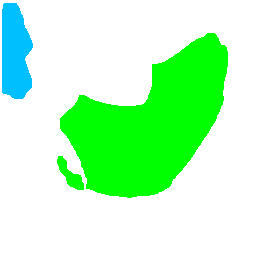

In [18]:
result[1]